# Airbnb: Where to Stay in Amsterdam?

By Group 9: Rahul Rathod, Yash Kapadia

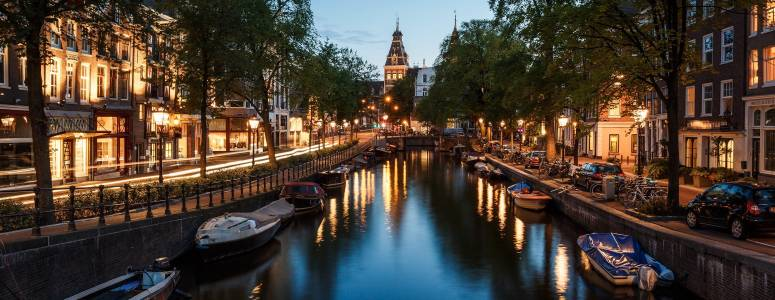

Airbnb has seen a meteoric growth since its inception in 2008 with the number of rentals listed on its website growing exponentially each year. Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers, not just the ones who are looking for a bang for their buck but also business travelers’ resort to Airbnb as their premier accommodation provider.

**Are you planning your trip to Amsterdam and searching for a place to stay on Airbnb? Before diving into thousands of listings posted online, you might be interested in some of the high-level information about the Amsterdam Airbnb market.**

# Loading the required Libraries

In [1]:
# importing the required packages for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins.marker_cluster import MarkerCluster
from folium.plugins import FastMarkerCluster
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
sns.set()
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso, Ridge
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

# Loading the Data 

The dataset consists of 6 structured csv files and 1 semi structured json file. The files are downloaded from insideairbnb.com and give a snapshot of the Amsterdam situation on February 14th, 2020. The 'listings' file contains all the advertisements in Amsterdam. The listings_details file contains additional variables. The calendar has 365 records for each listing. It specifies the whether the listing is available on a particular day (365 days ahead), and the price on that day. In addition, a reviews file is available that contains reviews about particular listings provided by travelers, and shapefile of the neighborhoods in Amsterdam. We have also used neighbourhood.geojson which is a dictionary that contains coordinates of neighborhoods. 

#### The Airbnb data of Amsterdam was retrieved from Kaggle (http://insideairbnb.com/get-the-data.html).The dataset includes the following files:

1. calendar.csv: The calendar has 365 records for each listing. It specifies the whether the listing is available on a particular day (365 days ahead), and the price on that day.

2. listings.csv: A listing is basically an advertisement. This file holds the most useful variables that can be used visualizations.

3. listings_details.csv: This file holds the same variables as the listing file plus 80 additional variables.

4. neighbourhood.csv: Simple file with the Dutch names of the neighbouhoods

5. reviews.csv: This is a simple file that can be used to count the number of reviews by listing (for a specific period).

6. reviews_details.csv: This file holds the full details of all reviews, and can also be used for instance for text mining.

7. neighbourhoods.geojson: This is the shape file that can be used in conjunction with interactive maps (such as Leaflet for R of the Python folium package).

In [2]:
# importing the required data files in to pandas dataframe
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
listing_details = pd.read_csv('listings_details.csv')
neighbourhood = pd.read_csv('neighbourhoods.csv')
review = pd.read_csv('reviews.csv')
reviews_details = pd.read_csv('reviews_details.csv')

# Data Preparation

The data prepartion steps include changing the data types of the required columns, dropping columns with NA values and filtering out rows which are not required. This is done for the sole purpose of our Exploratory Data Analysis. 

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20030 non-null  int64  
 1   name                            19992 non-null  object 
 2   host_id                         20030 non-null  int64  
 3   host_name                       20026 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   20030 non-null  object 
 6   latitude                        20030 non-null  float64
 7   longitude                       20030 non-null  float64
 8   room_type                       20030 non-null  object 
 9   price                           20030 non-null  int64  
 10  minimum_nights                  20030 non-null  int64  
 11  number_of_reviews               20030 non-null  int64  
 12  last_review                     

We see that neighbourhood_group is useless in Amsterdam, as it contains zero non-null objects.

In [4]:
calendar['date'] = pd.to_datetime(calendar['date'], errors ='coerce')
listings['last_review'] = pd.to_datetime(listings['last_review'], errors ='coerce')
listings = listings[listings['name'].notna()]
listings = listings[listings['host_name'].notna()]
listings = listings.drop('neighbourhood_group',axis='columns')



The listings_details file contains a total of 96 variables. We did not use all, but selectively joined a number of variables that seemed useful to me for this EDA.

In [5]:
listing_details = listing_details[['id','property_type','accommodates','first_review','review_scores_value',
                                  'review_scores_cleanliness','review_scores_location','review_scores_accuracy',
                                  'review_scores_communication','review_scores_checkin',
                                  'review_scores_rating','maximum_nights',
                                  'listing_url','host_is_superhost','host_about',
                                  'host_response_time','host_response_rate',
                                  'street','weekly_price','monthly_price','market']]

Merging of listings and listings_details for data analysis

In [6]:
final_listings = listings.merge(listing_details,on='id')

In [7]:
final_listings.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
1,3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100%,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100%,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100%,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100%,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


# Exploratory Data Analysis

# 1. Neighbourhoods

Neighbourhood "De Baarsjes - Oud-West" holds most listings, and altogether eight neigbourhoods have over one thousand listings.

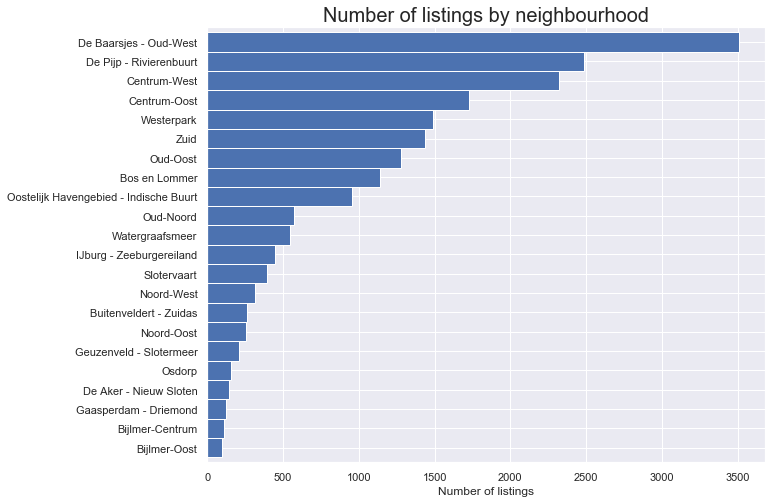

In [8]:
# Number of Listings by Neighbourhood
feq=final_listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

# 2. Most Number of Listings

This is an interactive map built using folium map library which shows the number of listings as clusters and we can drill down to a particular are to see the number of listings. Below, you can see that most listings are in the centre of the city

In [9]:
# Map showing the number of listings in Amsterdam

lats2018 = final_listings['latitude'].tolist()
lons2018 = final_listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

# 3. Room types

The room type is very important in Amsterdam, because Amsterdam has a rule that Entire homes/apartments can only be rented out via Airbnb for a maximum of 60 days a year. Below, we can see that this restriction applies to most of the listings.

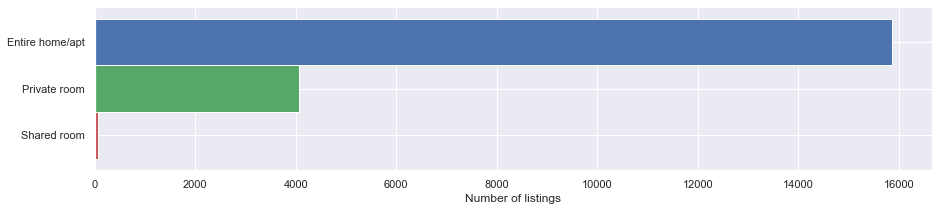

In [10]:
freq = final_listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["r","g","b"])
plt.xlabel('Number of listings', fontsize=12)
plt.show()

# 4. Accommodates (number of people)

There are more number of listings for 2 people. Airbnb uses a maximum of 16 guests per listing. However, Amsterdam has an additional restriction. Due to fire hazard considerations and also taking possible noisy group into account, owners are only allowed to rent their property to groups with a maximum of 4 people. This actually means that the listings that indicate that the maximum number of people is above 4 are breaking this rule!

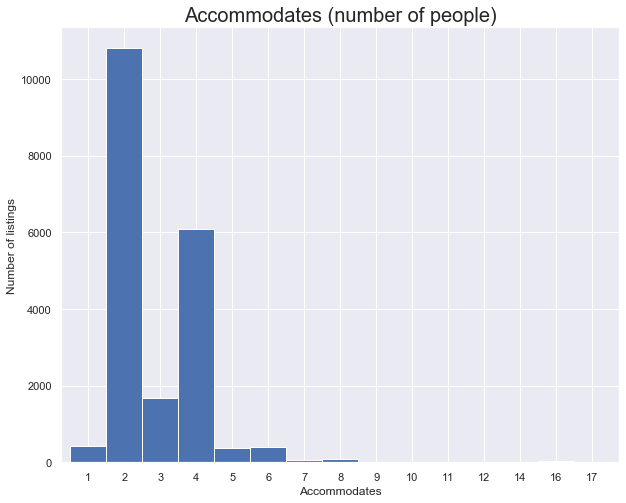

In [11]:
accom=final_listings['accommodates'].value_counts().sort_index()
accom.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

# 5. Availability over Time

In order to analyze the number of listings available for the customers we have plotted the graph for number of listings available for each date in the year 2019. Below, we see that up to three months ahead, there are generally more accomodations available than further into the future. Reasons for this might be that hosts are more actively updating their calendars in this timeframe. This graph is interactive, and hovering over the points will show you a tooltip with the "number of available listings" and "weekday" by date.

In [12]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

# 6. Average Review Scores for Neighbourhood

In this graph, we have explored the average reviews for the neighbourhoods where the number of reviews is greater than or equal to 10. Below we see that the central neighbourhoods, which were generally also the most expensive, generally also score higher on location review score. 

Text(0, 0.5, '')

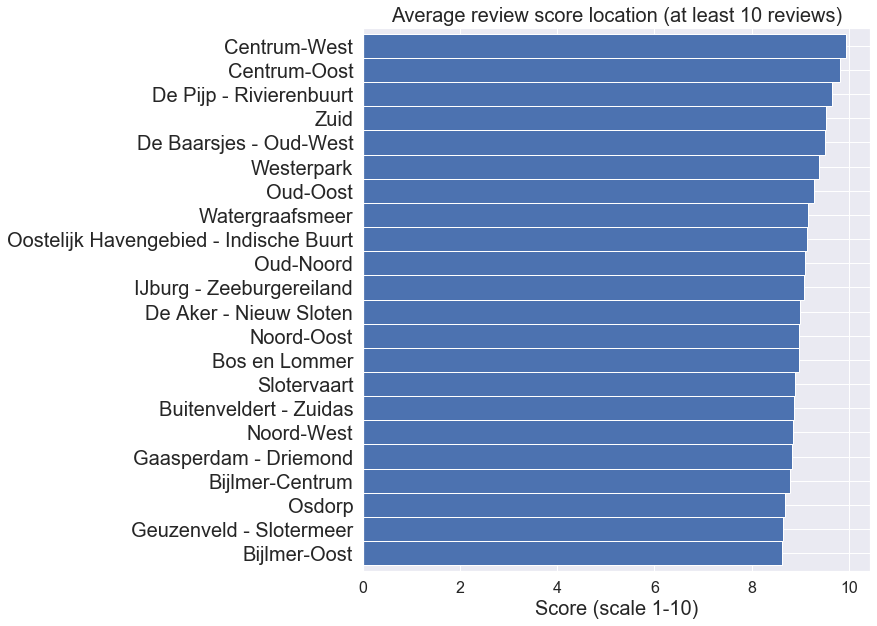

In [13]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = final_listings[final_listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot(color='b', width=1, kind='barh')
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")


# 7. Superhost

At Airbnb you can get the status "Superhost". From Airbnb:

As a Superhost, you’ll have more visibility, earning potential, and exclusive rewards. It's our way of saying thank you for your outstanding hospitality.
How to become a Superhost: 
- Every 3 months, we check if you meet the following criteria. If you do, you'll earn or keep your Superhost status.
- Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year.
- Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays.
- Superhosts have no cancellations in the past year, unless there were extenuating circumstances.
- Superhosts respond to 90% of new messages within 24 hours.


Below, we can see that only a small portion of the listings in Amsterdam do have a host who is Superhost

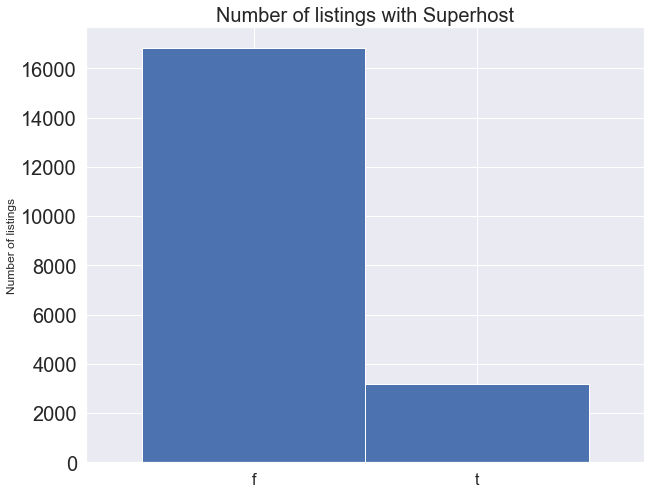

In [14]:
feq=final_listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

# Data Analysis - Price of the Listings

Business Questions:
- What is the distribution of price in Amsterdam Airbnb listings?
- Which factors of the property could affect the rental price on Airbnb?
- What is the average price according to the location of the neighbourhood?
- What is the average price according to the time of the year?

# Amsterdam Neighbourhoods Coordinates

We are using neighbourhoods.geojson to get the longitude and latitude of the center of each neighbourhood.

In [15]:
import geopandas as gpd
geo_ams = gpd.read_file('neighbourhoods.geojson')
geo_ams.head()

,neighbourhood,neighbourhood_group,geometry
0,Bijlmer-Oost,None,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,None,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,None,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,None,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,None,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."


In [16]:
geo_ams["longitude"] = geo_ams.centroid.x
geo_ams["latitude"] = geo_ams.centroid.y
geo_ams.drop('neighbourhood_group', axis=1, inplace=True)
geo_ams.head()

,neighbourhood,geometry,longitude,latitude
0,Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...",4.977317,52.320279
1,Noord-Oost,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...",5.003523,52.398339
2,Noord-West,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...",4.894589,52.415306
3,Oud-Noord,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...",4.910489,52.394068
4,IJburg - Zeeburgereiland,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...",4.998377,52.360899


# Time series analysis - price by date

Here we have merged the calendar data and listing_details data in order to find patterns in the average price of the listings over time.

In [17]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, final_listings[['id','accommodates']], left_on = "listing_id", right_on = 'id', how = "left")
calendar.sample(15)

,listing_id,date,available,price,id,accommodates
3047763,13619872,2019-10-12,f,NaN,13619872.0,4.0
4659079,19369338,2019-03-21,f,NaN,19369338.0,2.0
3964955,16800677,2019-09-19,f,NaN,16800677.0,4.0
4515773,19023296,2019-09-27,f,NaN,19023296.0,2.0
2542540,11589690,2019-07-19,t,$189.00,11589690.0,2.0
3751297,16003294,2019-05-28,f,NaN,16003294.0,3.0
4538342,19145903,2018-12-08,f,NaN,19145903.0,2.0
2902947,13312521,2019-05-13,t,$140.00,13312521.0,2.0
2085892,9266543,2019-01-18,f,NaN,9266543.0,3.0
1896301,8618260,2019-09-26,f,NaN,8618260.0,4.0


Data cleaning steps to clean the price column as it has a '$' sign

In [18]:
calendar['date'] = pd.to_datetime(calendar['date'], errors ='coerce')
calendar['price'] = calendar['price'].astype(str)
calendar['price'] = calendar['price'].apply(lambda x:x.lstrip('$'))
calendar['price'] = calendar['price'].apply(lambda x:x.replace(',',''))
calendar['price'] = calendar['price'].astype(float)

# What is the average price according to the time of the year?

Below, you see the average price of all 2-persons accomodations flagged as available by date. The peak of average price 240 Euro is at December 31st, and the cyclical pattern is due to higher prices in weekends. This graph is interactive, and hovering over the points will show you a tooltip with the average price and weekday by date.

In [19]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date'])[['price']].mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

# Data Cleaning for regression and statistical analysis

In [20]:
#we will use listings_details to explore airbnb properties
listings_details = pd.read_csv("listings_details.csv")

There are 96 columns in the airbnb data. But there are columns not valuable for our analysis such as listing_url, scrape_id. So, we can firstly filter some columns that are not describing the property. 

In [21]:
listings_details = listings_details[['id', 'name',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'price', 'cleaning_fee', 'guests_included', 'extra_people', 
       'minimum_nights', 'maximum_nights', 
       'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
       'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy']]

### Drop the unavaliable samples

In [22]:
#remove remove the properties are not availiable in the past recent months
listings_details = listings_details[listings_details['has_availability']=='t']
listings_details.shape

(20030, 35)

In [23]:
listings_details = listings_details[listings_details['availability_30']!=0]
listings_details = listings_details[listings_details['availability_60']!=0]
listings_details = listings_details[listings_details['availability_90']!=0]
listings_details = listings_details[listings_details['availability_365']!=0]
listings_details.shape

(8521, 35)

In [24]:
#drop the 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365' columns
listings_details.drop(['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'],axis=1, inplace=True)

### Drop the samples missing information

We would like to focus on the valid property only which means the property has a valid price and reviews from previous guests to verify the authenticity

In [25]:
#removing the unavailable samples
listings_details = listings_details[listings_details['price']!=0]
listings_details = listings_details[listings_details['number_of_reviews']!=0]
listings_details = listings_details[listings_details['review_scores_rating'].notnull()]

### Dealing with missing values

In [26]:
#examine missing values
listings_details.isnull().sum().sort_values(ascending=False)

square_feet                    7203
cleaning_fee                    965
bathrooms                         6
beds                              3
bedrooms                          3
review_scores_value               2
review_scores_location            2
review_scores_communication       2
review_scores_checkin             2
room_type                         0
accommodates                      0
latitude                          0
property_type                     0
longitude                         0
neighbourhood_cleansed            0
name                              0
bed_type                          0
cancellation_policy               0
price                             0
is_business_travel_ready          0
guests_included                   0
extra_people                      0
minimum_nights                    0
maximum_nights                    0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness   

In [27]:
#drop the column with many null values
listings_details.drop('square_feet',axis=1,inplace=True)

In [28]:
#fill missing values for beds, bathrooms and bedrooms by 0
listings_details['beds'].fillna(0,inplace=True)
listings_details['bathrooms'].fillna(0,inplace=True)
listings_details['bedrooms'].fillna(0,inplace=True)

In [29]:
#fill the missing sub-reviews by corresponding review_scores_rating¶
listings_details['review_scores_value'].fillna(listings_details['review_scores_rating'],inplace=True)
listings_details['review_scores_location'].fillna(listings_details['review_scores_rating'],inplace=True)
listings_details['review_scores_communication'].fillna(listings_details['review_scores_rating'],inplace=True)
listings_details['review_scores_checkin'].fillna(listings_details['review_scores_rating'],inplace=True)

In [30]:
#fill the missing cleaning fee by mode¶
listings_details['cleaning_fee'].fillna(listings_details['cleaning_fee'].mode()[0], inplace=True)

### Convert the type of some features

We can see there are some features related to price that should be numerical rather than categorical, such as price, cleaning_fee, extra_people. That is because the money data is recorded as a string in the format of '50$'. So we convert these money-related features to numbers.

In [31]:
#cleaning the price column
listings_details['price'] = listings_details['price'].apply(lambda x:x.lstrip('$'))
listings_details['price'] = listings_details['price'].apply(lambda x:x.replace(',',''))
listings_details['price'] = listings_details['price'].astype(float)

In [32]:
#cleaning the cleaning_fee column
listings_details['cleaning_fee'] = listings_details['cleaning_fee'].apply(lambda x:x.lstrip('$'))
listings_details['cleaning_fee'] = listings_details['cleaning_fee'].apply(lambda x:x.replace(',',''))
listings_details['cleaning_fee'] = listings_details['cleaning_fee'].astype(float)

In [33]:
#cleaning extra_people columns
listings_details['extra_people'] = listings_details['extra_people'].apply(lambda x:x.lstrip('$'))
listings_details['extra_people'] = listings_details['extra_people'].apply(lambda x:x.replace(',',''))
listings_details['extra_people'] = listings_details['extra_people'].astype(float)

# What is the distribution of prices in Amsterdam Airbnb listing?

let's see how the median of the prices distributied in different neighbourhoods

In [34]:
#median of the prices distributied in different neighbourhoods.
neighbourhood_price = listings_details.groupby('neighbourhood_cleansed').median()['price']
neighbourhood_price = pd.DataFrame({'neighbourhood':neighbourhood_price.index, 'price': neighbourhood_price.T.values})
neighbourhood_price.sort_values('price', ascending=False, inplace=True)
neighbourhood_price.head()

,neighbourhood,price
4,Centrum-Oost,160.0
5,Centrum-West,155.5
21,Zuid,140.0
8,De Pijp - Rivierenbuurt,140.0
7,De Baarsjes - Oud-West,139.0


## Distribution of price on the map
#### The neighbourhood closer to the center, the higher median of the prices it has. Top 2 neighbourhoods are Centrum-Oost, Centrum-West.

In [35]:
# The coordinates of Amsterdam center
latitude = 52.372952
longitude = 4.906080

map_ams_price = folium.Map(location=[latitude, longitude], zoom_start=12)
map_ams_price.choropleth(
    geo_data='neighbourhoods.geojson',
    data=neighbourhood_price,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='The average_price',
    reset=True
)
map_ams_price

We can see that it is true that the properties locating in Centrum-Oost and Centrum-West are more expensive than the others. It is worthy to mention these two neighbourhoods are the places where many famous places locate such as Anne Frank house, Red light district, Amsterdam museum. Also, it is interesting to see that IJburg - Zeeburgereiland also shows the high price even though it is not very close to the center. A reason could be the nice seaside scenery when living on the island

# Which factors of the property could affect the rental price on Airbnb?

Which factors of the property could affect the rental price on Airbnb? The answer of this question can be useful for people from Amsterdam who wants to start renting their properties on Airbnb, or tourists who are going to visit Amsterdam and want to estimate the cost of accommodation.

### Data Analytics

#### Examine the distribution of Price

Let's examine the normality of the price distribution

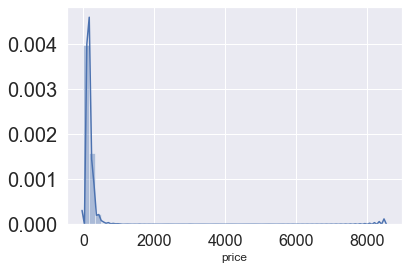

In [36]:
#examine the taget variable price
listings_details['price'].describe()
sns.set_style('darkgrid')
sns.distplot(listings_details['price'])
#we can see that target values is highley skewed 

### We can see that the distribution of price is highly skewed. Also, there are several outlier when the price is above 2000. We firstly remove outliers and then correct the distribution of the price by log function.


 mu = 4.93 and sigma = 0.52



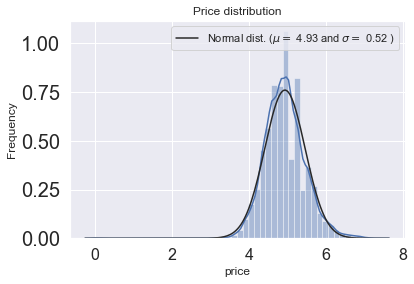

In [37]:
#removing outliers that are above 2000 
listings_details = listings_details[listings_details['price']<2000]
def correct_dist(price):
    price = np.log1p(price)

    #Check the new distribution 
    sns.distplot(price , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(price)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Price distribution')

    #Get also the QQ-plot
    plt.show()
    return price

listings_details['corrected_price'] = correct_dist(listings_details['price'])

### Get dummy categorical features

We used one hot encoder to encode the categorical features.

In [38]:
#creating dummy variables for all categorical objects
category_features = list(listings_details.dtypes[listings_details.dtypes == 'object'].index)
category_features.remove('name')
category_features

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy']

In [39]:
def one_hot_encode(data, columns):
    onehot = pd.get_dummies(data[columns])
    onehot['id'] = data['id']
    # move id column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    return onehot

In [40]:
#creating dummies for categorical features
dummy = one_hot_encode(listings_details,category_features)
dummy.head()

,id,neighbourhood_cleansed_Bijlmer-Centrum,neighbourhood_cleansed_Bijlmer-Oost,neighbourhood_cleansed_Bos en Lommer,neighbourhood_cleansed_Buitenveldert - Zuidas,neighbourhood_cleansed_Centrum-Oost,neighbourhood_cleansed_Centrum-West,neighbourhood_cleansed_De Aker - Nieuw Sloten,neighbourhood_cleansed_De Baarsjes - Oud-West,neighbourhood_cleansed_De Pijp - Rivierenbuurt,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60
0,2818,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3,25428,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
4,27886,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
5,28658,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
6,28871,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,1,0,0


### Merging all the features

Merged the features with dummy features by IDs of properties and Drop the duplicate categorical features that have already been encoded

In [41]:
#mergeing the encoded df with original df
final_df = pd.merge(listings_details,dummy)
#droping the categorical features
final_df.drop(category_features, axis=1, inplace=True)

In [42]:
#dropping irrelevant columns
y = final_df['corrected_price']
X = final_df.drop(['id', 'name', 'latitude', 'longitude', 'price','corrected_price'], axis=1)
X.shape

(7410, 81)

### Drop overfitting features

Drop the features that have more than 95% same values for all the data.

In [43]:
#removing overfitting variables
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 95:
        overfit.append(i)
overfit

['neighbourhood_cleansed_Bijlmer-Centrum',
 'neighbourhood_cleansed_Bijlmer-Oost',
 'neighbourhood_cleansed_Buitenveldert - Zuidas',
 'neighbourhood_cleansed_De Aker - Nieuw Sloten',
 'neighbourhood_cleansed_Gaasperdam - Driemond',
 'neighbourhood_cleansed_Geuzenveld - Slotermeer',
 'neighbourhood_cleansed_IJburg - Zeeburgereiland',
 'neighbourhood_cleansed_Noord-Oost',
 'neighbourhood_cleansed_Noord-West',
 'neighbourhood_cleansed_Oostelijk Havengebied - Indische Buurt',
 'neighbourhood_cleansed_Osdorp',
 'neighbourhood_cleansed_Oud-Noord',
 'neighbourhood_cleansed_Slotervaart',
 'neighbourhood_cleansed_Watergraafsmeer',
 'property_type_Aparthotel',
 'property_type_Barn',
 'property_type_Bed and breakfast',
 'property_type_Boat',
 'property_type_Boutique hotel',
 'property_type_Bungalow',
 'property_type_Cabin',
 'property_type_Casa particular (Cuba)',
 'property_type_Castle',
 'property_type_Chalet',
 'property_type_Condominium',
 'property_type_Cottage',
 'property_type_Guest suite'

In [44]:
X.drop(overfit, axis=1, inplace=True)

## Regression Modelling

Given the information of the property, we would like to predict its price. In this section, we are going to fit our data into multiple linear regression model and find the top 10 features affecting the price

To evaluate the performance of models, we firstly separate the data into training set and test set. The training set will be used to select and train the model, and the test set will be used to test the performance of the model.

In [45]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
regressor = LinearRegression()  

### Evalutaion Metric
We use the root of mean-squared-error (rmse) to measure how close the prediction to the actual price. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html. The lower rmse, the model is better.

In [47]:
# Root Mean Squared Logarithmic Error ，RMSE
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Model Fitting

In [48]:
regression_model= regressor.fit(X_train, y_train)
print('linear', rmse(y_train, regression_model.predict(X_train)))

linear 0.35573067449207396


### Results
The above rmsle score shows our model can accurately predict the price given the information data of the property. Once we have the trained model, more importantly, we would like to know which factor effect the price most. This can be done by examining the coef_ attribute of linear regression model which represent the importance scores of all features.

In [49]:
linear_model_list = {'Importance': regression_model}
feature_importance = []
for model_name, model in linear_model_list.items():
    feature_importance.append(model.coef_)

In [50]:
feature_importance = pd.DataFrame(feature_importance, columns=X_train.columns)
feature_importance.index = list(linear_model_list.keys())
feature_Importance =feature_importance.T
top5_factors = feature_Importance.sort_values(by=['Importance'],ascending=False).head(10)
top5_factors

,Importance
room_type_Entire home/apt,0.531568
neighbourhood_cleansed_Centrum-West,0.399425
neighbourhood_cleansed_Centrum-Oost,0.365117
neighbourhood_cleansed_De Pijp - Rivierenbuurt,0.224000
neighbourhood_cleansed_Zuid,0.195987
room_type_Private room,0.184985
neighbourhood_cleansed_De Baarsjes - Oud-West,0.180298
neighbourhood_cleansed_Westerpark,0.174293
neighbourhood_cleansed_Oud-Oost,0.134577
accommodates,0.110956


# Conclusion

According to the above table, there is no surprise that the room type, neighbourhood and number of accommodates are top 3 most important features to the price. Bigger house can accommodate more people therefore can be more expensive. Other related factors are the number of beds and the number of bathrooms.Location is definitely another important factor to the price. The review scores for location can reflect the neighbourhood the property locates and the how convenience the public transportation nearby. Property locating in the centrum neighbourhood can be more expensive than the others. This can by verified by the previous visualization of the medians of the prices of different neighbourhoods.